# **Churn Prediction**

I have used a dataset from **Kaggle**, which is the **Orange Telecom's Churn Dataset**, which consists of cleaned customer activity data (features), along with a churn label specifying whether a customer canceled the subscription

In [1]:
import pandas as pd

# Load the dataset (make sure the correct path is used)
df = pd.read_csv('/content/churn-bigml-80.csv')

# Display basic info about the dataset
print("Dataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      26

In [2]:

# Show summary statistics for numeric features
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
       Account length    Area code  Number vmail messages  Total day minutes  \
count     2666.000000  2666.000000            2666.000000         2666.00000   
mean       100.620405   437.438860               8.021755          179.48162   
std         39.563974    42.521018              13.612277           54.21035   
min          1.000000   408.000000               0.000000            0.00000   
25%         73.000000   408.000000               0.000000          143.40000   
50%        100.000000   415.000000               0.000000          179.95000   
75%        127.000000   510.000000              19.000000          215.90000   
max        243.000000   510.000000              50.000000          350.80000   

       Total day calls  Total day charge  Total eve minutes  Total eve calls  \
count      2666.000000       2666.000000        2666.000000      2666.000000   
mean        100.310203         30.512404         200.386159       100.023631   
std          19.98

In [4]:
# Check the distribution of the target variable (Churn)
print("\nChurn Distribution:")
print(df['Churn'].value_counts())



Churn Distribution:
Churn
False    2278
True      388
Name: count, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# 1. Handle categorical features
df['International plan'] = LabelEncoder().fit_transform(df['International plan'])
df['Voice mail plan'] = LabelEncoder().fit_transform(df['Voice mail plan'])
df['State'] = LabelEncoder().fit_transform(df['State'])

# 2. Feature Scaling for numerical features
scaler = StandardScaler()
scaled_features = ['Account length', 'Number vmail messages', 'Total day minutes',
                   'Total day calls', 'Total day charge', 'Total eve minutes',
                   'Total eve calls', 'Total eve charge', 'Total night minutes',
                   'Total night calls', 'Total night charge', 'Total intl minutes',
                   'Total intl calls', 'Total intl charge', 'Customer service calls']
df[scaled_features] = scaler.fit_transform(df[scaled_features])

# 3. Split the data into features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data size: {X_train.shape[0]}, Testing data size: {X_test.shape[0]}")

Training data size: 2132, Testing data size: 534


## Used Random Forest model, and perform hyperparameter tuning with RandomizedSearchCV for efficient tuning

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define the model
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning with RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Randomized search for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid,
                                   n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Train the model
random_search.fit(X_train, y_train)

# Get the best model
best_rf_model = random_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_rf_model.predict(X_test)

# Performance metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"\nROC AUC Score: {roc_auc:.4f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97       456
        True       0.95      0.69      0.80        78

    accuracy                           0.95       534
   macro avg       0.95      0.84      0.89       534
weighted avg       0.95      0.95      0.95       534


Confusion Matrix:
[[453   3]
 [ 24  54]]

ROC AUC Score: 0.8429


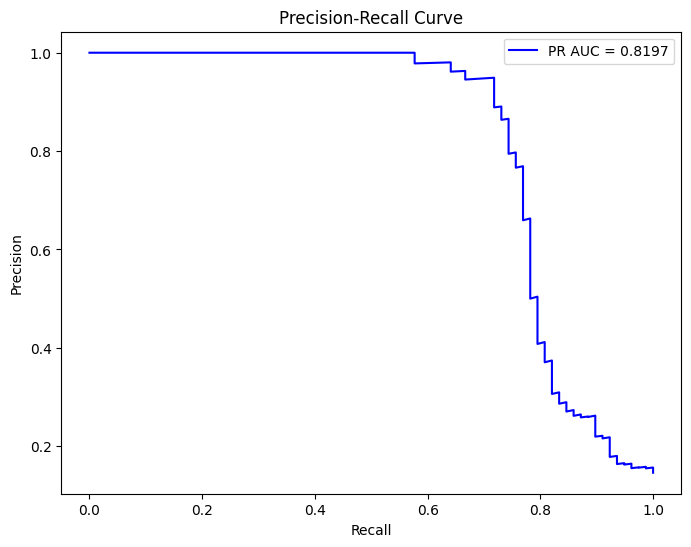

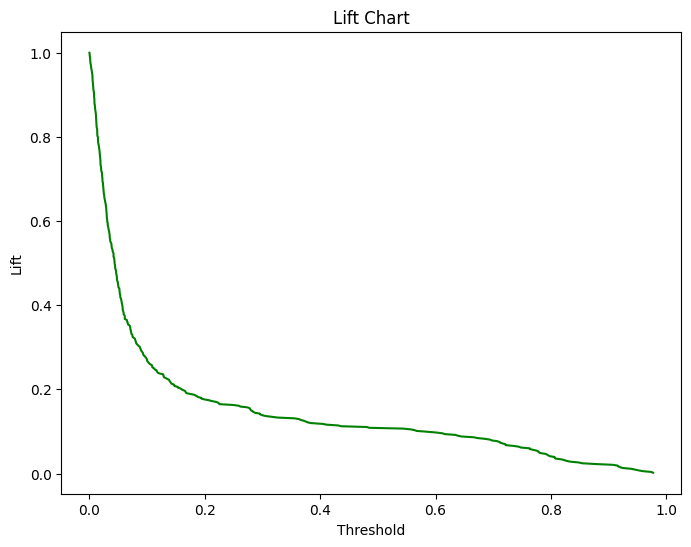

In [8]:
from sklearn.metrics import precision_recall_curve, auc

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR AUC = {pr_auc:.4f}')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

# Lift Chart (model performance)
# The 'Lift' measures how much better the model is at predicting high-risk customers compared to random guessing.
# We'll calculate Lift at different thresholds.
lift_values = []
for threshold in thresholds:
    y_pred_class = (best_rf_model.predict_proba(X_test)[:, 1] >= threshold).astype(int)
    lift = (y_pred_class == 1).sum() / len(y_pred_class)
    lift_values.append(lift)

# Plot Lift Chart
plt.figure(figsize=(8, 6))
plt.plot(thresholds, lift_values, color='green')
plt.title("Lift Chart")
plt.xlabel("Threshold")
plt.ylabel("Lift")
plt.show()


# Deployment

In [9]:
import joblib

# Save the trained model to a file
joblib.dump(best_rf_model, 'rf_churn_predictor_model.joblib')

print("Model saved as 'rf_churn_predictor_model.joblib'")


Model saved as 'rf_churn_predictor_model.joblib'


**After the model is saved as a serialized file, it can be served using an API.**